# libraries

In [1]:
#--- system libraries
import pdb
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
import traceback
import os
import scipy.interpolate as scp_int
import warnings
import matplotlib
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import patches
import sys
import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
import patsy
from sklearn import linear_model, mixture
import sklearn.mixture as skm
from scipy import optimize
import scipy
import re
from functools import reduce
#
warnings.filterwarnings('ignore')

#--- user modules
import LammpsPostProcess as lp
import imp
imp.reload(lp)

<module 'LammpsPostProcess' from '/Users/Home/Desktop/Tmp/txt/git/HeaDef/postprocess/LammpsPostProcess.py'>

In [2]:
#mpl.rcParams['text.usetex'] = True #--- comment tex stuff!

# utility funcs

In [10]:
def Zscore(val):
    x=val.copy()
    x -= np.mean(x)
    x /= np.std(x)
    return x

def PutMinorTicks(ax, LOGY=None,LOGX=None):
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    if LOGY:
        #--- add major yticks
        ymin=np.ceil(np.log10(ax.axis()[2]))
        ymax=np.floor(np.log10(ax.axis()[3]))
        nbin = ymax - ymin
        ax.set_yticks(np.logspace(ymin,ymax,int(nbin)+1))
        #--- put minor bins y
        locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1),numticks=12)
        ax.yaxis.set_minor_locator(locmin)
        ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    if LOGX:
        #--- add major yticks
        ymin=np.ceil(np.log10(ax.axis()[0]))
        ymax=np.floor(np.log10(ax.axis()[1]))
        nbin = ymax - ymin
        ax.set_xticks(np.logspace(ymin,ymax,int(nbin)+1))
        #--- put minor bins y
        locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1),numticks=12)
        ax.xaxis.set_minor_locator(locmin)
        ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
        
def GetPDF(slist, n_per_decade=4, ACCUM = None, linscale = None, density=True):
    if not linscale:
        xlo = np.floor(np.log10(np.min(slist)))
        xhi = np.ceil(np.log10(np.max(slist)))
        bins = np.logspace(xlo,xhi,int(xhi-xlo)*n_per_decade)    
    else:
        xlo = np.min(slist)
        xhi = np.max(slist)
        bins = np.linspace(xlo,xhi,n_per_decade)
        
    hist, edges = np.histogram(slist,bins=bins,density=density)
    count, edges = np.histogram(slist,bins=bins)
    
    
    if ACCUM:
        return np.cumsum((edges[1:]-edges[:-1])*hist), edges
    
    
    hist = hist[count>0]
    edges = edges[:-1][count>0]
    count = count[count>0]
    
    return  hist, edges, hist / count**0.5

def PltBitmap( value,
              xlabel = 'x', ylabel = 'y',
              xlim = (-0.5,0.5), ylim = (-0.5,0.5),
              frac = 1.0, #--- plot a patch
              zscore = True,
              title = 'cxy.png',
              colorbar=False,
              **kwargs
             ):
        
    val = value.copy()
    #--- z-score
    if zscore:
        val -= np.mean(val)
        val /= np.std(val)
        val[val>1.0]=1
        val[val<-1.0]=-1
    #--- plot
    (mgrid,ngrid) = val.shape
    center = (ngrid/2,mgrid/2)
    #
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.set_xlabel(xlabel,fontsize=20)
    ax.set_ylabel(ylabel,fontsize=20)
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
#     ax.axes.xaxis.set_visible(False)
#     ax.axes.yaxis.set_visible(False)
    #
    pos = ax.imshow(val.real,cmap='bwr',
                     extent=(xlim[0],xlim[1],ylim[0],ylim[1]),origin='lower')# ,vmin=-.6, vmax=.6)
    ax.set_xlim(xlim[0]*frac,xlim[1]*frac)
    ax.set_ylim(ylim[0]*frac,ylim[1]*frac)

    if colorbar:
        fig.colorbar( pos, fraction = 0.04)
    if 'DrawFrame' in kwargs: 
        DrawFrame(ax, *kwargs['DrawFrame'])
    plt.savefig(title,dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()
    
    

def GetAtoms( filee ):
    lmpData = lp.ReadDumpFile( filee )
    lmpData.GetCords( ncount = sys.maxsize, 
                     columns = {'c_peratom[1]':'sxx','c_peratom[2]':'syy','c_peratom[3]':'szz',
                                                       'c_peratom[4]':'sxy','c_peratom[5]':'sxz','c_peratom[6]':'syz'}
                    )
    itimee=list(lmpData.coord_atoms_broken.keys())

    #--- volume
    rad1=0.0#AtomicRadius[1]
    rad2=0.0#AtomicRadius[2]
    rad3=0.0#AtomicRadius[3]
    !ovitos OvitosCna.py $filee Voronoi.xyz 1 3 $rad1 $rad2 $rad3  
#--- read from d2min.xyz
    ovtData = lp.ReadDumpFile( 'Voronoi.xyz' )
    ovtData.GetCords( ncount = sys.maxsize)
    #--- atom obj
    box0 = map(lambda x:lp.Box( BoxBounds = lmpData.BoxBounds[x], AddMissing = np.array([0.0,0.0,0.0] ) ), itimee ) #--- reference state
    atoms0 = map(lambda x: lp.Atoms( **lmpData.coord_atoms_broken[x].to_dict(orient='series'),
                        AtomicVolume = ovtData.coord_atoms_broken[x]['AtomicVolume'].tolist()), itimee )

    return dict(zip(itimee,list(atoms0))), dict(zip(itimee,list(box0)))

def GetTimeAverageSeries( atoms, col='x' ):
    sarr = np.array(list(map( lambda x: atoms[x][col], atoms.keys() ))).T
    return np.mean(sarr,axis=1)

def GetTimeAverageAtom( atoms0 ):
    itime0 = list(atoms0.keys())[0]
    attrs=atoms0[itime0].__dict__.keys()
    sarr = np.array(list(map(lambda x: GetTimeAverageSeries( atoms0, col=x ), attrs))).T
    df = pd.DataFrame(sarr,columns=attrs)
    sdict= df.to_dict(orient='series')
    atomi=lp.Atoms(**sdict)
#    pd.DataFrame(atomi.__dict__)
    return atomi

# Parameters

In [ ]:
#--- comment out if no parameter is passed as an env. variable
env_vars = !cat .env
for var in env_vars:
    key, value = var.split('=')
    os.environ[key] = value

path = os.environ.get('path') #--- don't comment!

#--- uncomment if modified in 'submitPY.py'   
indx = int(os.environ.get('indx'))

In [56]:
RemoteMachine = True
#
#path = '/Users/Home/Desktop/Tmp/txt/annealed'


# parse data

In [57]:
#--- read initial atomic positions/stresses
atomi, boxi = GetAtoms( '%s/dump_init.xyz'%path )
atoms0 = GetTimeAverageAtom( atomi ) #--- argument: dic with key: time and val: atom object
#
itime0 = list(atomi.keys())[0]
box0=boxi[itime0]
#
atomd = {}
boxd = {}
ebulk = {}

#--- read data for deformed configurations
#for dir, mode in zip(range(1,7),['xx','yy','zz','yz','xz','xy']):
for dir, mode in zip([6],['xy']):
    atomt, boxt = GetAtoms( '%s/dump_def%s.xyz'%(path,dir) )
    atomd[mode] = GetTimeAverageAtom( atomt )
    #
    itime0 = list(atomt.keys())[0]
    boxd[mode] = boxt[itime0]
    #
    #--- evaluate strain
    if dir == 1 or dir == 2 or dir == 3:
        indxi = dir - 1
        indxj = dir - 1
    elif dir == 6: #--- xy
        indxi = 0
        indxj = 1
    dx=boxd[mode].CellVector[indxi,indxj]-box0.CellVector[indxi,indxj]
    l0=box0.CellVector[indxj,indxj]        
    ebulk[mode] = dx/l0    
ebulk['yz']=ebulk['xz']=ebulk['xx']
ebulk

InputFile= /Users/Home/Desktop/Tmp/txt/annealed/dump_init.xyz
num_frames= 1
InputFile= /Users/Home/Desktop/Tmp/txt/annealed/dump_def1.xyz
num_frames= 1
InputFile= /Users/Home/Desktop/Tmp/txt/annealed/dump_def2.xyz
num_frames= 1
InputFile= /Users/Home/Desktop/Tmp/txt/annealed/dump_def3.xyz
num_frames= 1
InputFile= /Users/Home/Desktop/Tmp/txt/annealed/dump_def4.xyz
num_frames= 1
InputFile= /Users/Home/Desktop/Tmp/txt/annealed/dump_def5.xyz
num_frames= 1
InputFile= /Users/Home/Desktop/Tmp/txt/annealed/dump_def6.xyz
num_frames= 1


{'xx': -9.999999999336923e-07,
 'yy': -9.999999999336923e-07,
 'zz': -9.999999999336923e-07,
 'yz': -9.999999999336923e-07,
 'xz': -9.999999999336923e-07,
 'xy': -1e-06}

In [58]:
pd.DataFrame(atoms0.__dict__).head()

,x,y,z,id,type,sxx,syy,szz,sxy,sxz,syz,AtomicVolume
0,-0.219232,-0.159382,-0.105477,1.0,3.0,1.631411e+05,508629.784766,680181.503728,176762.944943,74417.940879,-260844.325678,11.378475
1,1.590182,1.599994,-0.154754,2.0,2.0,-1.143522e+06,105366.691219,-253682.679893,-214411.943062,94243.832995,68287.100989,11.561379
2,1.625780,-0.183985,1.654177,3.0,2.0,4.139018e+05,312537.964065,278876.910144,-45967.401387,-134739.085023,-61189.096933,11.468856
3,-0.166116,1.630330,1.664170,4.0,3.0,5.062113e+05,590418.167100,449119.447518,-459589.959435,36241.525498,-239997.745056,11.486778
4,3.416902,-0.139878,-0.132331,5.0,3.0,1.061794e+06,338670.252034,827630.670044,47834.276691,-185261.639566,-65119.000217,11.418801


# elastic constants

In [59]:
cfac = 1.0e-4 #--- bar to gpa
dxx={}
dyy={}
dzz={}
dyz={}
dxz={}
dxy={}
for mode in ['xy']: #['xx','yy','zz','yz','xz','xy']:
    dxx[mode]=(atomd[mode].sxx/atomd[mode].AtomicVolume-atoms0.sxx/atoms0.AtomicVolume)/ebulk[mode]*cfac
    dyy[mode]=(atomd[mode].syy/atomd[mode].AtomicVolume-atoms0.syy/atoms0.AtomicVolume)/ebulk[mode]*cfac
    dzz[mode]=(atomd[mode].szz/atomd[mode].AtomicVolume-atoms0.szz/atoms0.AtomicVolume)/ebulk[mode]*cfac
    dyz[mode]=(atomd[mode].syz/atomd[mode].AtomicVolume-atoms0.syz/atoms0.AtomicVolume)/ebulk[mode]*cfac
    dxz[mode]=(atomd[mode].sxz/atomd[mode].AtomicVolume-atoms0.sxz/atoms0.AtomicVolume)/ebulk[mode]*cfac
    dxy[mode]=(atomd[mode].sxy/atomd[mode].AtomicVolume-atoms0.sxy/atoms0.AtomicVolume)/ebulk[mode]*cfac

## output dump

In [60]:
df=pd.DataFrame(atoms0.__dict__)
cols = list(df.keys())+['C66'] # + ['C55'] + ['C44']#--- C66 is cxyxy
df = pd.DataFrame(np.c_[df,dxy['xy'],
#                        dxz['xz'],
#                        dyz['yz']
                       ],
                  columns=cols)
atomm = lp.Atoms(**df)
wd = lp.WriteDumpFile(atomm, box0)
wd.Write('dump.xyz',attrs=cols)

## map

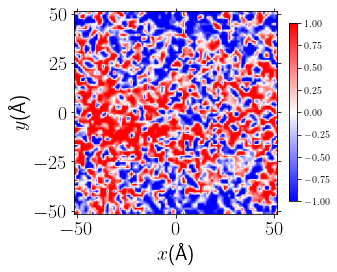

In [49]:
def Intrp( d2min, box0,times, time0, Plot = None ):
    #--- mean dist between atoms 
    natoms = len( d2min.x ) 
    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box0.CellVector )
    volume = np.linalg.det( CellVectorOrtho )
    dmean = 0.5*( volume / natoms ) ** (1.0/3.0) 


    #--- grid tiling mapped box with original size
    #--- values are interpolated onto this grid
    (xlin, ylin, zlin), (xv, yv, zv) = lp.GetCubicGrid( box0.CellOrigin, 
                                                     box0.CellVector, 
                                                     dmean,
                                                     margin = 0.0 * dmean )
    xi = np.array(list(zip(xv.flatten(), yv.flatten(), zv.flatten())))

    #--- expand the original box
        #--- map to square box
    mapp = lp.Map( d2min, box0 ) 
    mapp.ChangeBasis()
    mapp.Set( d2min ) #--- atoms: add mapped xyz

    cptmp = lp.Copy(d2min, box0) #--- important: must be reference frame!!
    cptmp.Expand( epsilon = 0.2, mode = 'isotropic' )
    d2exp = cptmp.Get()

    points = np.c_[d2exp.xm,d2exp.ym,d2exp.zm] #--- unstructured points
    values = np.array(d2exp.C66) #(np.array(d2exp.C66)+np.array(d2exp.C55)+np.array(d2exp.C44))/3.0 #np.c_[-(np.array(d2exp.sxx)+np.array(d2exp.syy)+np.array(d2exp.szz))/3.0/np.array(d2exp.AtomicVolume)] #--- corresponding values

    grid_z = scp_int.griddata(points, values, xi, method='linear')
    assert not np.any(np.isnan(grid_z.flatten())), 'increase ev!'

    #--- make an object
    d2intrp = lp.Atoms(**pd.DataFrame(np.c_[xi,grid_z],columns=['x','y','z','d2min']).to_dict(orient='list'))

    if Plot:
    #--- reshape value
        nx,ny,nz = len(xlin), len(ylin),len(zlin) 
        value = np.c_[d2intrp.d2min].reshape(((ny,nx,nz)))

        CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box0.CellVector ) #--- box length
        #--- xy plane
        zc=0.5*(zlin[0]+zlin[-1])
        dz = zlin[-1]-zlin[-2]
        lz = zlin[-1]-zlin[0]
        #
        zz = [zc,zlin[-1]][1]
        nzz=int(nz*(zz-zlin[0])/lz)
        if nzz == nz: nzz -= 1
        val = value[:,:,nzz].copy()
        #
        PltBitmap(val, 
                  xlabel = r'$x$(\r{A})', ylabel = r'$y$(\r{A})',
                  xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
                  zscore = True,
                  frac = 1.0, #--- plot a patch
                  title = 'd2min.png',
                  colorbar=True,
                )

    return (xlin, ylin, zlin), (xv[:,:,nzz], yv[:,:,nzz], zv[:,:,nzz]), d2intrp
  
if 1: #not RemoteMachine:
    junk, (xv, yv, zv), d2intrp = Intrp(atomm, box0,
                    times = [0],
                    time0 =0,
                    Plot = True,
                   )

In [50]:
pd.DataFrame(atomm.__dict__).head()

,x,y,z,id,type,sxx,syy,szz,sxy,sxz,syz,AtomicVolume,C44,C55,C66,xm,ym,zm
0,-0.126636,-0.149294,-0.144672,1.0,3.0,778244.533262,1.525260e+06,1.033408e+06,-277732.920495,438646.555199,-169120.630498,11.073320,95.500795,168.691509,91.458058,-0.126636,-0.149294,-0.144672
1,1.597725,1.572808,-0.217069,2.0,2.0,61460.100739,-1.936764e+05,1.002315e+05,-15324.633705,-106664.334188,-230084.383526,11.020133,115.742187,87.047337,77.153435,1.597725,1.572808,-0.217069
2,1.605476,-0.194358,1.601241,3.0,2.0,-10936.944617,-3.093520e+05,5.943345e+04,272940.528394,-3663.665218,-141453.219482,10.924568,99.082311,90.585554,86.351849,1.605476,-0.194358,1.601241
3,-0.164551,1.544091,1.568590,4.0,2.0,-182966.789997,1.104632e+05,-1.205413e+05,-62258.355962,108268.998601,2102.996028,10.931718,48.123804,54.429049,99.831913,-0.164551,1.544091,1.568590
4,3.374807,-0.165961,-0.169075,5.0,2.0,641216.217403,6.607546e+03,6.000434e+05,189424.475635,-34785.584856,-17818.708148,11.163416,75.179036,117.019540,98.408831,3.374807,-0.165961,-0.169075


### map and scatterd plot 

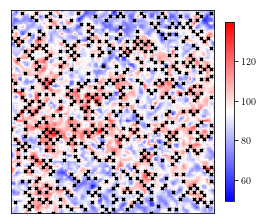

In [51]:
def PltBitmapWithScatter( value, xyScatter,
              xlabel = 'x', ylabel = 'y',
              xlim = (-0.5,0.5), ylim = (-0.5,0.5),
              frac = 1.0, #--- plot a patch
              zscore = True,
              title = 'cxy.png',
              colorbar=False,
              ticklabels=True,
              color='black',
              **kwargs
             ):
        
    val = value.copy()
    #--- z-score
    if zscore:
        val -= np.mean(val)
        val /= np.std(val)
        val[val>2.0]=1.0
        val[val<-2.0]=-1.0
    #--- plot
    (mgrid,ngrid) = val.shape
    center = (ngrid/2,mgrid/2)
    #
    aspect = (ylim[1]-ylim[0])/(xlim[1]-xlim[0])
    fig = plt.figure(figsize=(4,4*aspect))
    ax = fig.add_subplot(111)
    ax.set_xlabel(xlabel,fontsize=16)
    ax.set_ylabel(ylabel,fontsize=16)
    ax.tick_params(labelsize=16,which='both',axis='both', top=True, right=True)
    if not ticklabels:
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
    #
    pos = ax.imshow(val.real,cmap='bwr',
                     extent=(xlim[0],xlim[1],ylim[0],ylim[1]),origin='lower')# ,vmin=-.6, vmax=.6)
    
    ax.scatter(xyScatter[:,0],xyScatter[:,1],
           alpha=1,color=color,marker='x',s=10)
        
        
    if colorbar:
        fig.colorbar( pos, fraction = 0.04)
    if 'DrawFrame' in kwargs: 
        DrawFrame(ax, *kwargs['DrawFrame'])
    plt.savefig(title,dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()
    
def Intrp( d2min, box0,times, time0, title = 'bitmap', Plot = None ):
    d2intrp = {}
    for itime in times:
        #--- mean dist between atoms 
        natoms = len( d2min.x ) 
        CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box0.CellVector )
        volume = np.linalg.det( CellVectorOrtho )
        dmean = 0.5*( volume / natoms ) ** (1.0/3.0) 


        #--- grid tiling mapped box with original size
        #--- values are interpolated onto this grid
        (xlin, ylin, zlin), (xv, yv, zv) = lp.GetCubicGrid( box0.CellOrigin, 
                                                         box0.CellVector, 
                                                         dmean,
                                                         margin = 0.0 * dmean )
        xi = np.array(list(zip(xv.flatten(), yv.flatten(), zv.flatten())))

        #--- expand the original box
            #--- map to square box
        mapp = lp.Map( d2min, box0 ) 
        mapp.ChangeBasis()
        mapp.Set( d2min ) #--- atoms: add mapped xyz

        cptmp = lp.Copy(d2min, box0) #--- important: must be reference frame!!
        cptmp.Expand( epsilon = 0.2, mode = 'isotropic' )
        d2exp = cptmp.Get()

        points = np.c_[d2exp.xm,d2exp.ym,d2exp.zm] #--- unstructured points
        values = d2exp.C66 #np.c_[-(np.array(d2exp.sxx)+np.array(d2exp.syy)+np.array(d2exp.szz))/3.0/np.array(d2exp.AtomicVolume)] #--- corresponding values

        grid_z = scp_int.griddata(points, values, xi, method='linear')
        assert not np.any(np.isnan(grid_z.flatten())), 'increase ev!'

        #--- make an object
        d2intrp[ itime ] = lp.Atoms(**pd.DataFrame(np.c_[xi,grid_z],columns=['x','y','z','d2min']).to_dict(orient='list'))

        if Plot:
        #--- reshape value
            nx,ny,nz = len(xlin), len(ylin),len(zlin) 
            value = np.c_[d2intrp[ itime ].d2min].reshape(((ny,nx,nz)))

            CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box0.CellVector ) #--- box length
            #--- xy plane
            zc=0.5*(zlin[0]+zlin[-1])
            dz = zlin[-1]-zlin[-2]
            lz = zlin[-1]-zlin[0]
            #
            zz = [zc,zlin[-1]][1]
            nzz=int(nz*(zz-zlin[0])/lz)
            if nzz == nz: nzz -= 1
            val = value[:,:,nzz].copy()
            
            #--- filter
            zlo=(zz-dz-zlin[0]) % lz + zlin[0]
            zhi=(zz+dz-zlin[0]) % lz + zlin[0]

            indxx= np.all([d2min.z > zlo, 
                           d2min.z < zhi
                          ],
                            axis=0)
            
            if zhi < zlo: #--- periodicity
                indxx= np.any([d2min.z > zlo, 
                               d2min.z < zhi
                              ],
                                axis=0)


            indices = d2min.type == 1 #--- Ni 3
            indxx = np.all([indxx,indices],axis=0)

            PltBitmapWithScatter(val, 
                  np.c_[np.array(d2min.x)[indxx],np.array(d2min.y)[indxx]],
                  xlabel = '', ylabel = '',
    #                  xlim=VectorNorm[0]*np.array([0.0,1.0]),ylim=VectorNorm[1]*np.array([0.0,1.0]),
                  xlim=np.array([xlin[0],xlin[-1]]),ylim=np.array([ylin[0],ylin[-1]]),
                  zscore = False,
                  frac = 1.0, #--- plot a patch
                  title = '%s%s.png'%(title,itime),
                  colorbar=True,
                  ticklabels = False,
                  color='black',
    #                     DrawFrame=[0.2,0.09,0.15,0.06,0.04],
                  )
                
                

    return (xlin, ylin, zlin), (xv[:,:,:], yv[:,:,:], zv[:,:,:]), d2intrp, indxx, val
  
if not RemoteMachine:
    junk, (xv, yv, zv), d2intrp, filtr, value = Intrp(atomm, box0,
                    times = [0], #list(lmpData.coord_atoms_broken.keys()),
                    time0 =0,
                    Plot = True,
                    title = 'cr',
                   )

## pdf

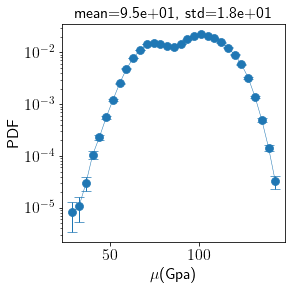

In [61]:
def Pdf( value, ax,  label='',
             ):
    #--- size distribution
    hist, edges2, error = GetPDF( value, linscale = True, n_per_decade=32)

#
    np.savetxt('data_annealed.txt',np.c_[edges2,hist,error])
    ax.errorbar(edges2,hist,error,fmt='-o',
                markersize=8,markeredgewidth=0.7,
                    linewidth=.5, zorder=1,
                     barsabove=None,capsize=5,capthick=1,elinewidth=1,label=label)
    #
        

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.set_yscale('log')
#ax.set_xscale('log')
# ax.set_ylim(1e-5,10)
# ax.set_xlim(1e-2,1e4)
#ax.set_xlabel(r'$(p-\bar{p})\times w^{3/2}$',fontsize=16)
ax.set_xlabel([r'$(p-\bar{p})/\sigma_p$',r'$\mu$(Gpa)'][1],fontsize=16)
ax.set_ylabel(r'PDF',fontsize=16)
ax.tick_params(labelsize=16)
#ax.set_title(r'itime=%s'%itime)
#--- fit        
x=np.linspace(-4,4,1000)
y=np.exp(-0.5*x**2)/(2*np.pi)**.5
#
var={}
iitype=1 #--- Ni
Pdf( atomm.C66, #(atomm.C66+atomm.C55+atomm.C44)/3.0, #-np.mean(value))/var[key], 
      ax, #label='rc=%2.1f'%key,
#    zscore = True, 
#    xlim=[0.33-d,.33+d,.33+d,.33-d,-.8,.8],
#    title='scatter3d.%s.png'%(x[1]),
    )

mu=(atomm.C66).mean() #((atomm.C44+atomm.C55+atomm.C66)/3).mean()
mu_std=(atomm.C66).std() #((atomm.C44+atomm.C55+atomm.C66)/3).std()
ax.set_title('mean=%2.1e, std=%2.1e'%(mu,mu_std), fontsize=16)
#plt.plot(x,y,'.-',color='black',zorder=2)
#ax.legend(frameon=False, fontsize=12)
plt.savefig('pdf.png',dpi=75,bbox_inches='tight')
plt.show()


### comparison

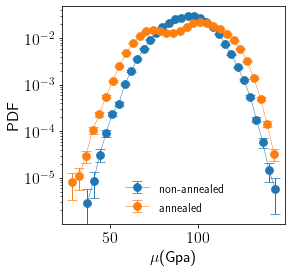

In [64]:
data0=np.loadtxt('data_nonannealed.txt')
data1=np.loadtxt('data_annealed.txt')

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
#
ax.set_yscale('log')
#ax.set_xscale('log')
#
ax.set_xlabel([r'$(p-\bar{p})/\sigma_p$',r'$\mu$(Gpa)'][1],fontsize=16)
ax.set_ylabel(r'PDF',fontsize=16)
#
ax.tick_params(labelsize=16)
#
ax.errorbar(data0[:,0],data0[:,1],data0[:,2],fmt='-o',
            markersize=8,markeredgewidth=0.7,
                linewidth=.5, zorder=1,
                 barsabove=None,capsize=5,capthick=1,elinewidth=1,label='non-annealed')
#
ax.errorbar(data1[:,0],data1[:,1],data1[:,2],fmt='-o',
            markersize=8,markeredgewidth=0.7,
                linewidth=.5, zorder=1,
                 barsabove=None,capsize=5,capthick=1,elinewidth=1,label='annealed')
#
ax.legend(frameon=False, fontsize=12)
#
plt.savefig('pdfCompare.png',dpi=75,bbox_inches='tight')
#
plt.show()

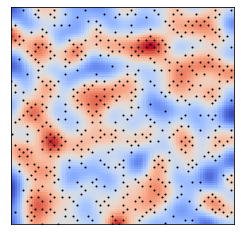

In [217]:
from scipy.ndimage import gaussian_filter

def reset_xticks(nn,ax,TMIN,TMAX):
    ax.set_xticks( np.linspace(ax.axis()[0],ax.axis()[1],nn) ) 
    labels=np.linspace(TMIN,TMAX,nn)
    labels = [r'$%i$'%i for i in labels]
    ax.set_xticklabels(labels)

def reset_yticks(nn,ax,RMIN,RMAX):
    ax.set_yticks( np.linspace(ax.axis()[2],ax.axis()[3],nn) ) 
    labels=np.linspace(RMIN,RMAX,nn)
    labels = [r'$%i$'%i for i in labels]
    ax.set_yticklabels(labels)
    
    
def GetInterpolatedData( x,y, TMIN,TMAX,RMIN,RMAX ):
    r2nd=4.8 #--- g(r)
    nbins_x=nbins_y=xv.shape[0]
    sigma = int(r2nd/((TMAX-TMIN)/nbins_x))
#    print(sigma)
#    df=df0.copy()

#    df['T*']=df[ 'T*' ].apply(lambda x: log(x,10))
#    df['R*']=df[ 'R*' ].apply(lambda x: log(x,10))
    heatmap, xedges, yedges = np.histogram2d( x, y, bins=[np.linspace(TMIN,TMAX,nbins_x+1), np.linspace(RMIN,RMAX,nbins_y+1)], normed=True)
    heatmap *= len( x )
    heatmap = gaussian_filter( heatmap, sigma = sigma )
    return heatmap

def DensityMap(atoms0, filtr, xv, yv):
    xs = np.array(atoms0.x)[filtr]
    ys = np.array(atoms0.y)[filtr]

    heatmap=GetInterpolatedData(xs,ys,
                                xv.min(), xv.max(),yv.min(),yv.max())

    fig=plt.figure(figsize=(4,4))
    ax=fig.add_subplot(111)
    ax.pcolormesh(heatmap.T,cmap='coolwarm')




    reset_xticks(4,ax,xv.min(),xv.max())
    #--- reset y-ticks
    reset_yticks(4,ax,yv.min(),yv.max())

        #--- mapping
    xx=ax.axis()[0]+(ax.axis()[1]-ax.axis()[0])*(xs-xv.min())/(xv.max()-xv.min())
    yy=ax.axis()[2]+(ax.axis()[3]-ax.axis()[2])*(ys-yv.min())/(yv.max()-yv.min())
    ax.set_xlim(ax.axis()[0],ax.axis()[1])
    ax.set_ylim(ax.axis()[2],ax.axis()[3])

    ax.scatter(xx,yy,
               alpha=1,color='black',s=1)
    
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)


    plt.savefig('density.png',dpi=75,bbox_inches='tight')
    plt.show()
    
    return heatmap.T
    

rho = DensityMap(atoms0, filtr, xv, yv)

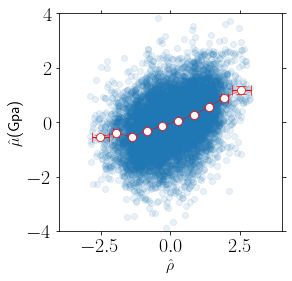

In [218]:
def GetBinnedAverage( a, y, **kwargs ):
    n=len(a)
    if 'nbins_per_decade' in kwargs:
        nbins = kwargs['nbins_per_decade'] * int( ( np.ceil(np.max(a))-np.floor(np.min(a)) ) )
    if 'nbins' in kwargs:
        nbins = kwargs['nbins']
    
    ysum = np.histogram(a, bins=nbins, weights=y)[0]
    xsum = np.histogram(a, bins=nbins, weights=a)[0]
    xcount = np.histogram(a, bins=nbins)[0]

#    print xsum
#    print xcount
#    assert not np.any(xcount==0)
    #--- remove zero
    xsum = xsum[xcount!=0]
    ysum = ysum[xcount!=0] 
    xcount = xcount[xcount!=0]

    xmean = xsum/xcount
    ymean = ysum/xcount
    return xmean, ymean, xmean / xcount ** 0.5, ymean / xcount ** 0.5

def PlotScatter(x,y,PLOT_AVERAGE=False,**kwargs):
    
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    #
    if 'xlim' in kwargs:
        ax.axis(kwargs['xlim'])
    if 'Logy' in kwargs and kwargs['Logy']:
        ax.set_yscale('log')
    if 'Logx' in kwargs and kwargs['Logx']:
        ax.set_xscale('log')
    #
    ax.set_ylabel(kwargs['ylabel'] if 'ylabel' in kwargs else '',fontsize=16)
    ax.set_xlabel(kwargs['xlabel'] if 'xlabel' in kwargs else '',fontsize=16)
    #
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #
    cxy=0.0
    if 'zscore' in kwargs and kwargs['zscore']:
        x = Zscore(x)
        y = Zscore(y)
        cxy = np.sum(x*y)/len(x)
        
    ax.scatter(x,y,
               alpha=.1)#,c=col,label=elm)#,marker='x')
    #
    if PLOT_AVERAGE:
        xb, yb, err_x, err_y = GetBinnedAverage( x, y,nbins=10) #, nbins_per_decade = 8 )
        nevery = int(np.ceil(len(xb)/10.0))
        ax.errorbar(x=xb,y=yb,yerr=err_y,xerr=err_x,
            fmt='-o', markersize=8,color='red',markerfacecolor='white',markeredgewidth=0.7,
                    markeredgecolor='red', markevery=nevery, errorevery=nevery,
            linewidth=.5, barsabove=None,capsize=5,capthick=1,elinewidth=1)
#                 def func(x,a,b):
#                     return a*x+b
#                 z = np.polyfit(xb, yb, 1)

#                 label = r'$%2.1e.x+%2.1e$'%(z[0],z[1])
    
    #
#     DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04,LOG_Y=True)
    if 'Logy' in kwargs and kwargs['Logy'] and 'Logx' in kwargs and kwargs['Logx']:
        PutMinorTicks( ax, LOGY = True, LOGX=True)
    #
    plt.savefig('scatter.png',dpi=75,bbox_inches='tight',pad_inches=0.0)
    plt.show()

    return cxy
    
    

if not RemoteMachine:
    cxy = PlotScatter(rho.flatten(),value.flatten(),
                PLOT_AVERAGE = True,
               zscore = True,
               xlim=[-4,4,-4,4],
#               Logx=True, Logy=True,
               ylabel = r'$\hat\mu$(Gpa)',
               xlabel = r'$\hat\rho$',
               )


In [19]:
help(sklearn)

Help on package sklearn:

NAME
    sklearn

DESCRIPTION
    Machine learning module for Python
    
    sklearn is a Python module integrating classical machine
    learning algorithms in the tightly-knit world of scientific Python
    packages (numpy, scipy, matplotlib).
    
    It aims to provide simple and efficient solutions to learning problems
    that are accessible to everybody and reusable in various contexts:
    machine-learning as a versatile tool for science and engineering.
    
    See http://scikit-learn.org for complete documentation.

PACKAGE CONTENTS
    __check_build (package)
    _build_utils (package)
    _config
    _distributor_init
    _isotonic
    _loss (package)
    _min_dependencies
    base
    calibration
    cluster (package)
    compose (package)
    conftest
    covariance (package)
    cross_decomposition (package)
    datasets (package)
    decomposition (package)
    discriminant_analysis
    dummy
    ensemble (package)
    exceptions
    experime

In [22]:
import sklearn.model_selection
help(sklearn.model_selection.train_test_split)

Help on function train_test_split in module sklearn.model_selection._split:

train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)
    Split arrays or matrices into random train and test subsets
    
    Quick utility that wraps input validation and
    ``next(ShuffleSplit().split(X, y))`` and application to input data
    into a single call for splitting (and optionally subsampling) data in a
    oneliner.
    
    Read more in the :ref:`User Guide <cross_validation>`.
    
    Parameters
    ----------
    *arrays : sequence of indexables with same length / shape[0]
        Allowed inputs are lists, numpy arrays, scipy-sparse
        matrices or pandas dataframes.
    
    test_size : float or int, default=None
        If float, should be between 0.0 and 1.0 and represent the proportion
        of the dataset to include in the test split. If int, represents the
        absolute number of test samples. If None, the value is set to t

In [8]:
from sklearn.decomposition import PCA
help(PCA)

Help on class PCA in module sklearn.decomposition._pca:

class PCA(sklearn.decomposition._base._BasePCA)
 |  PCA(n_components=None, *, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)
 |  
 |  Principal component analysis (PCA).
 |  
 |  Linear dimensionality reduction using Singular Value Decomposition of the
 |  data to project it to a lower dimensional space. The input data is centered
 |  but not scaled for each feature before applying the SVD.
 |  
 |  It uses the LAPACK implementation of the full SVD or a randomized truncated
 |  SVD by the method of Halko et al. 2009, depending on the shape of the input
 |  data and the number of components to extract.
 |  
 |  It can also use the scipy.sparse.linalg ARPACK implementation of the
 |  truncated SVD.
 |  
 |  Notice that this class does not support sparse input. See
 |  :class:`TruncatedSVD` for an alternative with sparse data.
 |  
 |  Read more in the :ref:`User Guide <PCA>`.
 |  
 | 